In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Dependencies
import gym
import random
import numpy as np
from collections import deque
from keras.layers import Dense,Activation, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam
# from keras.mish import Mish
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
# Environment
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Seed
seed = 5
env.seed(seed)
random.seed(seed)
np.random.seed(seed)

In [0]:
# Training parameterss
discount_factor = 0.99
epsilon_decay = 0.995
epsilon_min = 0.01
batch_size = 32
train_start = 1000
memory_size = 10000
n_episodes = 2000
n_win_ticks = 195
n_avg_scores = 100
render = False

In [4]:
# Build model
def build_model():
    model = Sequential()
    model.add(Dense(96, input_dim=state_size, kernel_initializer='he_uniform'))
    # model.add(Mish())
    model.add(Activation('relu'))
    model.add(Dense(48, kernel_initializer='he_uniform'))
    # model.add(Mish())
    model.add(Activation('relu'))
    model.add(Dense(24, kernel_initializer='he_uniform'))
    # model.add(Mish())
    model.add(Activation('relu'))
    model.add(Dense(action_size, kernel_initializer='he_uniform'))
    model.compile(Adam(lr=0.001), loss='mse')
    return model

model = build_model()
target_model = build_model()

model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 96)                480       
_________________________________________________________________
activation_1 (Activation)    (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 48)                4656      
_________________________________________________________________
activation_2 (Activation)    (None, 48)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                1176      
_________________________________________________________________
activation_3 (Activation)    (None, 24)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)            

In [0]:

def update_target_model():
    target_model.set_weights(model.get_weights())

def get_action(state, epsilon):
    return np.random.randint(action_size) if np.random.rand() <= epsilon else np.argmax(model.predict(state)[0])

def train_replay():
    if len(memory) < train_start:
        return
    minibatch = random.sample(memory,  min(batch_size, len(memory)))
    state_t, action_t, reward_t, state_t1, terminal = zip(*minibatch)
    state_t = np.concatenate(state_t)
    state_t1 = np.concatenate(state_t1)
    targets = model.predict(state_t)
    Q_sa = target_model.predict(state_t1)
    targets[range(batch_size), action_t] = reward_t + discount_factor * np.max(Q_sa, axis=1) * np.invert(terminal)
    model.train_on_batch(state_t, targets)







[Episode 0] Average Score: 27.0


[Episode 100] Average Score: 14.14
Solved after 120 tries! \o/
[Episode 200] Average Score: 235.73
[Episode 300] Average Score: 313.63
[Episode 400] Average Score: 325.78
[Episode 500] Average Score: 395.52
[Episode 600] Average Score: 400.42
[Episode 700] Average Score: 333.32
[Episode 800] Average Score: 360.07
[Episode 900] Average Score: 449.2
[Episode 1000] Average Score: 288.41
[Episode 1100] Average Score: 396.15
[Episode 1200] Average Score: 432.13
[Episode 1300] Average Score: 431.24
[Episode 1400] Average Score: 457.86
[Episode 1500] Average Score: 429.96
[Episode 1600] Average Score: 466.15
[Episode 1700] Average Score: 379.24
[Episode 1800] Average Score: 470.16
[Episode 1900] Average Score: 246.61


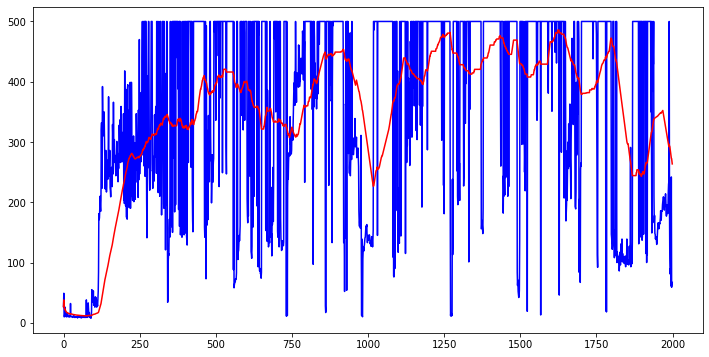

In [6]:
# Training
avg_scores = []
all_scores = []
scores = deque(maxlen=n_avg_scores)
memory = deque(maxlen=memory_size)

def balance_action():
    epsilon = 1.0 # Start with randomness
    has_won = False

    for e in range(n_episodes):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            action = get_action(state, epsilon)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            memory.append((state, action, reward if not done else -100, next_state, done))
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay # Decrease randomness
            train_replay()
            score += reward
            state = next_state
            
            if render:
                env.render()

            if done:
                env.reset()
                update_target_model()
                scores.append(score)
                all_scores.append(score)
                avg_score = np.mean(scores)
                avg_scores.append(avg_score)

                if not has_won and e >= n_avg_scores and avg_score >= n_win_ticks:
                    # Find first score greater than 195 where the average is >= 195 over the following 100 episodes.
                    solution_episode_idx = max(next(x[0] for x in enumerate(all_scores) if x[1] >= n_win_ticks), e - n_win_ticks) 
                    print('Solved after {} tries! \o/'.format(solution_episode_idx))
                    has_won = True

                if e % n_avg_scores == 0:
                    print('[Episode {}] Average Score: {}'.format(e, avg_score))

balance_action()

# Plot results
plt.figure(figsize=(12,6))
plt.plot(all_scores, color='blue')
plt.plot(avg_scores, color='red')
plt.show()